In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import sympy as sp
from math import sin,cos,tan
import pandas as pd
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split

In [2]:
test_data= pd.read_csv("Test.csv")
trian_data = pd.read_csv("Train.csv")

In [3]:
ID = test_data["ID"]
location = test_data["location"]
print(location)
temp = test_data["temp"]
precip = test_data["precip"]
rel_humidity = test_data["rel_humidity"]
wind_dir = test_data["wind_dir"]
wind_spd = test_data["wind_spd"]
atmos_press = test_data["atmos_press"]

ID1= trian_data["ID"]
location1= trian_data["location"]
temp1= trian_data["temp"]
precip1= trian_data["precip"]
rel_humidity1= trian_data["rel_humidity"]
wind_dir1= trian_data["wind_dir"]
wind_spd1= trian_data["wind_spd"]
atmos_press1= trian_data["atmos_press"]
target1 = trian_data["target"]

train_data = np.vstack((ID1,location1,temp1,precip1,rel_humidity1,wind_dir1,wind_spd1,atmos_press1,target1))
test_data = np.vstack((ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press))

0       C
1       C
2       D
3       C
4       D
       ..
5030    C
5031    D
5032    E
5033    A
5034    C
Name: location, Length: 5035, dtype: object


In [4]:
location_trian = np.zeros((15539,1,121))
location_test = np.zeros((5035,1,121))
for i in range(0,len(location_trian)):
    if location1[i] == "A":
        location_trian[i,0,:] = 1.0
    if location1[i] == "B":
        location_trian[i,0,:] = 2.0
    if location1[i] == "C":
        location_trian[i,0,:] = 3.0
    if location1[i] == "D":
        location_trian[i,0,:] = 4.0
    if location1[i] == "E":
        location_trian[i,0,:] = 5.0
        
for j in range(0,len(location_test)):
    if location[j] == "A":
        location_test[j,0,:] = 1.0
    if location[j] == "B":
        location_test[j,0,:] = 2.0
    if location[j] == "C":
        location_test[j,0,:] = 3.0
    if location[j] == "D":
        location_test[j,0,:] = 4.0
    if location[j] == "E":
        location_test[j,0,:] = 5.0
print(location_test[1,0,:])

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3.]


In [5]:
mat_data_train = np.zeros((15539,6,121))
mat_data_mean_std = np.zeros((15539,6,2))

def find_persentages(train_data,Persentage_req_data):
    indexes = []
    for i in range(0,len(train_data[0])):
        count = 0
        count1 = 0
        for p in range(2,len(train_data)-1):
            listt = train_data[p][i]
            listt = listt.split(',')
            listt2 = []
            count1 += len(listt)
            for j in range(0,len(listt)):
                if listt[j] != "nan":
                    listt2.append(float(listt[j]))
                    count += 1 
            mat_data_mean_std[i,p-2,0] = np.max(listt2)
            mat_data_mean_std[i,p-2,1] = np.min(listt2)
        persentage_data = count/count1
        if persentage_data<Persentage_req_data:
            indexes.append(i)
    return indexes

for i in range(0,len(train_data[0])):
    for p in range(2,len(train_data)-1):
        listt = train_data[p][i]
        listt = listt.split(',')
        listt2 = []
        for j in range(0,len(listt)):
            if listt[j] != "nan":
                listt2.append(float(listt[j]))       
        if len(listt2) !=0:
            mean = np.mean(listt2)
            std = np.std(listt2)
            
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = ss.norm.rvs(loc = mean,scale = std)
                    mat_data_train[i,p-2,k] = float(value)
                else:
                    mat_data_train[i,p-2,k] = float(string)
        else:
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = 0
                    mat_data_train[i,p-2,k] = float(value)
                else:
                    mat_data_train[i,p-2,k] = float(string)

In [6]:
indexes = find_persentages(train_data,0.7)
mat_data_train_fin = np.zeros((15539,7,121))
mat_data_train_fin[:,0:6,:]=mat_data_train
mat_data_train_fin[:,6:6,:]=location_trian

data_set_input = np.delete(mat_data_train_fin,indexes,axis = 0)
print(data_set_input.shape)
mat_data_mean_std = np.delete(mat_data_mean_std,indexes,axis = 0)

(14000, 7, 121)


In [7]:
def Scaling(array,maxx,minn):
    diff = maxx-minn
    if diff != 0:
        m = 5/(maxx-minn)
        c = 5-maxx*m
        for i in range(len(array)):
            if array[i] != -999:
                array[i] = m*array[i]+c
    return array

def Scaling_targets(array):
    maxx =np.max(array)
    minn =np.min(array)
    if maxx-minn != 0:
        m = 2/(maxx-minn)
        c = 1-maxx*m
        
    array = m*np.array(array)+c
    return array
    
    
for i in range(len(data_set_input)):
    for j in range(len(data_set_input[i])-1):
        array = data_set_input[i,j,:]
        scaled_array= Scaling(array,np.max(mat_data_mean_std[:,j,0]),np.min(mat_data_mean_std[:,j,1]))
        data_set_input[i,j,:] = scaled_array
     

In [8]:
print(data_set_input[0,0,:])

[1.92307692 1.74358975 1.54945055 1.58241758 1.55860806 1.3974359
 1.22893773 1.1007326  1.0970696  1.06776557 1.04945055 1.04395604
 1.28021978 1.78754579 2.4029304  2.82967033 3.38278388 3.71794872
 3.87912088 4.07692308 4.22527473 4.30952381 4.35897436 3.80402931
 3.02564103 2.82967033 2.61355311 2.77838828 2.1978022  1.8974359
 1.81501832 1.58791209 1.69047619 1.76739927 1.62087912 1.87362637
 2.05128205 1.87912088 2.21245421 2.20695971 2.46153846 3.13553114
 3.74908425 4.0018315  4.01282051 4.003663   3.93040293 3.37912088
 2.65567766 2.31135531 2.17582418 2.19230769 2.02380953 1.78205128
 1.62087912 1.45787546 1.26373626 1.17399267 1.0952381  0.92307692
 1.02747253 1.79120879 2.1996337  2.58791209 3.07142857 3.48901099
 3.86996337 3.97802198 4.08241758 4.15934066 4.         3.75091575
 3.3003663  2.79304029 2.43589744 2.32600733 2.03113553 1.87728938
 1.72893773 1.53113553 1.47069597 1.28754579 1.26007326 1.27289377
 1.36630037 2.1043956  2.5989011  2.87912088 2.76373626 2.976190

In [9]:
num_samp = len(data_set_input)
split_in = 0.2
data_set_input = np.reshape(data_set_input,(14000,7,121,1))

target = [float(k) for k in target1]
targets = np.delete(target,indexes)
#targets = Scaling_targets(target)
train_in, test_in,train_out,test_out = train_test_split(data_set_input, targets, test_size=split_in)
print(train_in.shape)
print(train_out.shape)
print(test_in.shape)
print(test_out.shape)

(11200, 7, 121, 1)
(11200,)
(2800, 7, 121, 1)
(2800,)


In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),strides=(1, 1), padding="valid", activation='relu', input_shape=(7, 121,1)))
model.add(layers.MaxPooling2D( pool_size=(2, 10), strides=(1, 5),padding="same"))
model.add(layers.Conv2D(64, (2, 2),padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(1, 6),padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 119, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 24, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 24, 64)         8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 2, 64)          36928     
Total params: 45,504
Trainable params: 45,504
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 119, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 24, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 24, 64)         8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 2, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy',tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(train_in, train_out, epochs=100,batch_size = 32, 
                    validation_data=(test_in, test_out))

Epoch 1/100
350/350 [==============================] - 9s 26ms/step - loss: 1799.1019 - accuracy: 0.0000e+00 - root_mean_squared_error: 42.4158 - val_loss: 1548.8556 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 39.3555
Epoch 2/100
350/350 [==============================] - 9s 25ms/step - loss: 1572.6698 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.6569 - val_loss: 1511.0121 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.8717
Epoch 3/100
350/350 [==============================] - 9s 25ms/step - loss: 1541.2766 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.2591 - val_loss: 1470.3485 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.3451
Epoch 4/100
350/350 [==============================] - 9s 25ms/step - loss: 1523.1532 - accuracy: 0.0000e+00 - root_mean_squared_error: 39.0276 - val_loss: 1500.5648 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 38.7371
Epoch 5/100
350/350 [==============================] - 9s 26ms/step - lo

350/350 [==============================] - 10s 28ms/step - loss: 455.3264 - accuracy: 0.0000e+00 - root_mean_squared_error: 21.3384 - val_loss: 923.2098 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 30.3844
Epoch 37/100
350/350 [==============================] - 9s 27ms/step - loss: 440.3680 - accuracy: 0.0000e+00 - root_mean_squared_error: 20.9849 - val_loss: 887.9109 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 29.7978
Epoch 38/100
350/350 [==============================] - 10s 29ms/step - loss: 442.1138 - accuracy: 0.0000e+00 - root_mean_squared_error: 21.0265 - val_loss: 994.8131 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 31.5407
Epoch 39/100
350/350 [==============================] - 10s 28ms/step - loss: 445.5755 - accuracy: 0.0000e+00 - root_mean_squared_error: 21.1087 - val_loss: 903.8894 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 30.0648
Epoch 40/100
350/350 [==============================] - 9s 26ms/step - loss: 419.1921 

350/350 [==============================] - 9s 26ms/step - loss: 269.2471 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.4088 - val_loss: 864.8926 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 29.4091
Epoch 72/100
350/350 [==============================] - 9s 25ms/step - loss: 257.7657 - accuracy: 0.0000e+00 - root_mean_squared_error: 16.0551 - val_loss: 833.6053 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 28.8722
Epoch 73/100
350/350 [==============================] - 9s 26ms/step - loss: 245.0783 - accuracy: 0.0000e+00 - root_mean_squared_error: 15.6550 - val_loss: 905.1293 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 30.0854826 - accuracy: 0.0000e+00 - root_mean_squared_error: - ETA: 1s - loss: 245.3490 - accuracy: 0.0000e+00 - root_mean_squa
Epoch 74/100
350/350 [==============================] - 9s 25ms/step - loss: 252.1714 - accuracy: 0.0000e+00 - root_mean_squared_error: 15.8799 - val_loss: 934.6319 - val_accuracy: 0.0000e+00 - val_ro

In [13]:
mean_train = np.mean([32.8142,29.6790,31.8867,33.59,30.9128,29.9082])
mean_test = np.mean([35.3493,33.4154,35.3549,34.84,31.8757,33.2425])

std_train = np.std([32.8142,29.6790,31.8867,33.59,30.9128,29.9082])
std_test = np.std([35.3493,33.4154,35.3549,34.84,31.8757,33.2425])

print('mean_train: {}'.format(mean_train))
print('mean_test: {}'.format(mean_test))
print('std_train: {}'.format(std_train))
print('std_test: {}'.format(std_test))


mean_train: 31.465149999999998
mean_test: 34.01296666666667
std_train: 1.4394526433683057
std_test: 1.2773129082396208


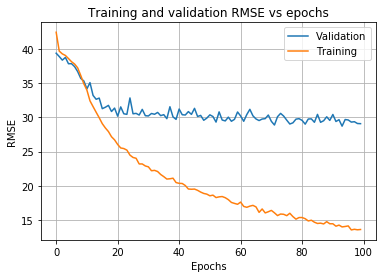

In [14]:
plt.figure(1)
plt.title('Training and validation RMSE vs epochs')
plt.plot(history.history["val_root_mean_squared_error"],label = "Validation")
plt.plot(history.history["root_mean_squared_error"],label = "Training")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.grid()

In [ ]:
mat_data_test = np.zeros((5035,6,121))
mat_data_mean_std_test = np.zeros((5035,6,2))

def find_persentages_2(test_data,Persentage_req_data):
    indexes = []
    for i in range(0,len(test_data[0])):
        count = 0
        count1 = 0
        for p in range(2,len(test_data)):
            listt = test_data[p][i]
            listt = listt.split(',')
            listt2 = []
            count1 += len(listt)
            for j in range(0,len(listt)):
                if listt[j] != "nan":
                    listt2.append(float(listt[j]))
                    count += 1 
            mat_data_mean_std_test[i,p-2,0] = np.max(listt2)
            mat_data_mean_std_test[i,p-2,1] = np.min(listt2)
        persentage_data = count/count1
        if persentage_data<Persentage_req_data:
            indexes.append(i)
    return indexes
for i in range(0,len(test_data[0])):
    for p in range(2,len(test_data)):
        listt = test_data[p][i]
        listt = listt.split(',')
        listt2 = []
        for j in range(0,len(listt)):
            if listt[j] != "nan":
                listt2.append(float(listt[j]))       
        if len(listt2) !=0:
            mean = np.mean(listt2)
            std = np.std(listt2)
            
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = ss.norm.rvs(loc = mean,scale = std)
                    mat_data_test[i,p-2,k] = float(value)
                else:
                    mat_data_test[i,p-2,k] = float(string)
        else:
            for k in range(len(listt)):
                string = listt[k]
                if string == 'nan':
                    value = 0
                    mat_data_test[i,p-2,k] = float(0)
                else:
                    mat_data_test[i,p-2,k] = float(string)
                    


In [ ]:
indexes2 = find_persentages_2(test_data,0.7)

mat_data_test_fin = np.zeros((5035,7,121))
mat_data_test_fin[:,0:6,:]=mat_data_test
mat_data_test_fin[:,6:6,:]=location_test

data_set_input_test = mat_data_test_fin

#data_set_input_test = np.delete(mat_data_train,indexes,axis = 0)
#mat_data_mean_std = np.delete(mat_data_mean_std,indexes,axis = 0)

    
for i in range(len(data_set_input_test)):
    for j in range(len(data_set_input_test[i])-1):
        array = data_set_input_test[i,j,:]
        maximum = np.max(mat_data_mean_std[:,j,0])
        minimum = np.min(mat_data_mean_std[:,j,1])
        scaled_array= Scaling(array,maximum,minimum)
        data_set_input_test[i,j,:] = scaled_array
        
print(mat_data_mean_std_test[314,4,1])      
data_set_input_test = np.reshape(data_set_input_test,(5035,7,121,1))


In [ ]:
values = model.predict(data_set_input_test)
mean_target = np.mean(target)
print(mean_target)
for i in range(len(indexes2)):
    ind = indexes2[i]
    values[ind,0] = mean_target


In [ ]:
df = pd.DataFrame(values)

filepath = 'predictions.xlsx'

df.to_excel(filepath, index=False)

In [ ]:
0
126.7774811
40.59076309
30.25740623
58.66954803
40.61304855
58.19250488
64.68920135
54.98119736
23.23841858
77.3350296
42.44355774
25.77736855
43.71857071
97.66994476
95.95131683
66.34659576
64.05332184
72.41791534
38.00677109
34.75043106
61.64061737
36.94877625
33.84787369
42.75596237
40.85382462
49.10919189
33.04433823
129.2029572
35.0487709
42.66016006
35.99810028
95.91576385
156.2065887
29.87547493
45.6032486
67.6873703
49.7543335
223.0050354
65.8815918
58.22623825
37.54816818
34.9969635
18.27013397
35.66459274
76.96109772
61.03193665
24.2979641
67.20386505
79.34102631
37.03857422
51.56493759
44.93027878
35.28319168
87.96890259
27.94052887
47.27930832
99.71707916
38.72022629
33.57849503
37.78790665
59.46015549
51.06870651
25.87018394
57.09024811
27.67106819
42.39262772
34.30112076
39.89642334
60.80938339
33.83670425
49.34054947
50.67382431
41.00720596
58.71437454
51.74113846
39.13007355
74.37000275
27.92524529
30.0651722
33.44763947
26.65349197
38.3427887
269.0239868
74.44004059
56.58484268
120.4560928
67.30065155
71.8782196
37.48661423
63.74528885
54.20789337
41.99088287
78.01786804
18.32761955
114.5238876
106.4251022
44.94231796
173.8591309
55.94571304
52.88925552
32.08108139
44.47413254
50.57087708
68.37300873
38.62584305
27.47811699
90.55866241
33.2247467
59.34179688
47.92441177
31.95401192
58.98791122
56.77888107
50.51161575
38.04434586
38.05683517
72.61626434
75.33934021
66.87397003
101.2280197
32.85593414
38.00084686
85.28475189
72.59276581
45.88757324
87.41291809
62.3515358
31.56307793
186.8689728
84.23297119
28.60676003
50.91915894
80.66335297
67.80781555
71.42292023
38.274086
53.13817596
33.62773132
78.20848846
42.87127304
44.79771805
79.09255219
41.67097855
41.89829636
21.15420914
42.50237656
32.40942764
43.71055222
19.64400482
54.19709396
29.86928749
26.72979927
91.399086
48.29302597
26.28484917
52.20674515
50.57609558
53.04184341
54.2040329
53.08611679
37.71639252
41.59840775
36.62205124
59.2936058
223.0821533
42.10400772
43.44355392
25.73251534
109.9046707
45.41088486
180.6781616
45.22787857
41.39517593
30.37200737
21.05990601
25.51654434
96.98412323
42.07604599
47.54705429
77.27619934
36.58450699
46.72322464
42.86912918
31.61863136
56.84580994
38.84016418
59.08349228
34.9226532
48.1778183
41.57186508
20.43359184
37.32091522
96.51392365
44.81875992
37.32999039
37.93237305
29.53616524
57.01131058
85.69400787
108.9902267
87.60935211
28.12026787
48.91718292
73.62421417
41.95946503
29.60219002
35.05321503
51.45969009
97.44512177
48.84444046
33.91947556
118.6011505
33.8854599
64.89576721
76.90811157
72.69381714
39.96047592
41.78264999
44.45850372
78.53359222
53.94616318
69.22312164
61.26741028
83.88140106
87.6734314
61.04619217
45.34846115
49.36175919
25.2890873
41.57304764
45.77905273
37.92095566
110.5949097
49.758358
36.41391373
84.48587036
94.93985748
29.03991699
66.2259903
32.1950798
80.44678497
86.5100174
136.135498
35.68788528
49.04626083
40.47680283
63.28400803
49.81754684
72.21359253
103.311882
31.13640785
27.47711372
56.90486145
44.65295792
43.21150589
144.1334076
85.64266205
61.59393692
24.66599846
54.62975693
44.92625427
67.96382141
48.06603622
25.20681572
57.82953262
69.072258
79.15493774
47.86163712
33.35393906
42.3506813
43.81725311
60.83267593
104.1514359
44.42834854
53.54327774
53.34803009
60.47941971
43.75394058
59.78798294
40.77669144
195.7515869
45.1074791
45.23994827
61.70779037
30.60226059
135.9621735
76.60874939
64.418396
64.85116577
27.22686386
43.79858398
33.32863235
34.12352371
59.51498413
43.06240463
102.7891312
48.12141037
35.29261017
50.86567307
83.71424103
45.93122101
161.0970612
41.07595825
50.13659286
42.58440781
155.3740845
42.3329277
70.6036911
178.804245
70.96807098
78.66159821
48.79371262
83.09304047
46.45495224
34.45854568
54.38242722
47.63315964
59.73246002
40.41884232
42.55009842
30.10928917
84.24931335
92.60408783
23.75255775
75.8536911
52.73959351
68.53466797
73.782547
23.11341667
28.43288803
47.59732056
33.43659592
44.27789307
178.2033997
69.94199371
83.07585907
24.81148148
66.83080292
39.27729797
28.79384041
32.03171539
65.17281342
41.78024673
40.6177063
40.97838974
51.52904892
51.34357834
56.96156311
31.66726875
45.25617218
30.70921898
36.46793365
59.03492355
29.31434441
40.66340256
76.66323853
107.51194
27.4438076
141.136795
31.29345131
44.65477371
70.81965637
56.03279114
35.01099777
44.59639359
27.46716881
76.21954346
43.70339584
41.77495575
106.5226135
111.1705856
36.83321762
46.80828094
32.68570709
48.59982681
324.6726074
117.5594711
38.99695206
110.2580338
54.93618393
86.86087799
32.99457169
66.08242798
40.79685211
43.35483932
27.25789261
39.29156113
63.04681396
80.88083649
48.45975113
19.65183067
41.94714355
36.41813278
61.76955032
154.7985077
22.04180336
57.42744827
37.48528671
26.59707832
37.67631912
88.71738434
62.40974808
46.79854202
183.0579224
60.31457901
64.04023743
29.52815056
58.52752304
28.52668953
32.99598312
35.11496353
37.91943359
88.86912537
88.79564667
38.53854752
56.4034462
21.62582016
80.2921524
83.1444931
72.42063141
34.23410797
34.08768845
51.77220154
25.8967495
64.43721008
54.90393066
36.75971222
32.20636749
44.35286331
56.09826279
34.54811478
46.99882889
57.68413162
62.82471848
29.52566147
26.59964561
82.47280121
67.39562988
43.55055618
63.10292816
160.3366699
25.47976875
61.01253128
79.31813812
59.78916931
37.95721054
41.72532272
51.72457123
84.51732635
59.31832504
53.41215897
68.35114288
64.74507904
42.02486801
25.56428719
37.03778458
82.41336823
45.57539749
76.21090698
47.72410202
31.50096703
36.28571701
241.085022
43.25946808
34.34108353
47.01327133
70.06787872
25.10785866
91.93406677
35.81341934
144.6813812
69.71508026
59.14226532
51.62564468
52.01659775
46.54478836
87.81187439
58.99094772
53.25779724
27.5435791
153.9620514
74.60366058
49.68001556
38.30207062
87.22303009
41.5010376
66.63876343
49.73940659
87.89308929
42.95190811
59.63811111
53.71313858
48.73550415
66.15291595
44.33510208
44.6596756
52.85123825
56.69525909
70.11640167
162.5321655
47.83195877
66.42895508
45.1353569
32.71240997
18.26928139
35.94200897
100.5739212
63.01938248
95.27651215
63.38135147
64.26473236
53.59680557
71.31282806
93.61401367
29.80785561
146.3515167
64.48889923
30.72343254
78.79620361
29.5107708
48.70988083
46.15327072
17.19566154
69.59418488
40.4717865
73.18476105
71.12007904
49.98898697
105.2301407
67.98410797
64.18022919
31.72485924
35.59712219
156.7025452
82.19865417
154.9106598
35.05511093
97.00708008
49.68266678
54.54117966
26.21606445
72.94841766
110.7529068
63.62687683
56.21117783
72.16184235
50.31680679
135.6480408
43.57186127
58.8873024
55.59305954
124.8062744
33.19524002
103.8925247
45.52029037
68.00990295
64.59669495
24.66189003
29.33839607
68.29967499
27.48361015
43.65669632
37.63953781
128.9829712
56.88970947
49.37125397
108.4378128
34.47843933
57.56958771
27.55618095
36.77889633
70.05677032
33.16735458
44.41340256
35.34368515
66.83049011
27.59230614
39.59151077
101.0801163
74.686203
29.2507019
94.25003052
23.20874214
29.59581566
47.75587082
34.35165024
60.36971664
31.64953995
55.79981995
40.96150589
90.88820648
129.7626495
92.2636261
28.46171761
37.90032578
31.59699249
40.8684845
53.67172623
46.79656982
68.5371933
93.77141571
120.3074875
50.66408539
63.79299545
24.21185493
36.16998672
53.12799454
120.3217163
37.39889908
49.61844254
63.67525864
21.30625725
49.74398422
76.429039
53.85520172
38.39587021
40.08089066
52.50585175
32.53488159
32.94991302
79.53613281
10.54099655
58.91090012
53.91285706
87.13065338
45.72980118
118.6045914
68.10010529
99.5574646
18.26873207
38.00111008
69.1492157
41.53667831
35.17598724
37.22788239
56.42369461
44.52450943
52.96157074
70.85211945
41.35411835
45.2256012
102.4686966
93.24526978
49.62076187
71.44485474
46.47298813
50.64089584
90.21633148
59.37533569
41.87630844
43.95560455
47.89832306
33.12028503
46.49900436
48.90540314
52.64297104
98.65925598
98.73918915
47.14221573
164.8237
61.63363647
75.26538086
22.07914925
49.30028915
68.0602951
32.63780212
51.60396957
299.282959
37.94658279
43.00727463
177.2282562
17.23053169
67.32170105
70.53350067
47.14790726
44.28045654
64.80757904
50.89480591
48.7783165
36.77960968
134.8786621
208.3633423
32.64308548
33.1734581
35.21685028
53.75857162
95.62921906
40.10619736
42.47072601
36.41858673
31.58797646
63.81701279
85.20163727
28.27126503
22.1032238
69.04165649
58.65139389
38.86073685
83.84374237
57.81457901
31.69391632
37.65740204
39.65135574
60.38208389
38.23242188
31.28946114
112.6995773
19.34153938
35.11991501
54.54411697
19.11709976
41.30369949
21.89638901
30.05857277
163.3630981
73.15401459
60.57727432
47.52219772
39.37868881
27.37815666
31.85460281
94.36063385
36.11651993
42.97738266
120.0565262
23.59397697
55.79970932
26.78724289
27.31832695
21.12682724
50.32177353
32.88868332
33.31350327
89.14940643
72.68695831
85.4697113
55.32539749
76.27972412
118.9034882
102.4370804
37.18571472
33.52252579
59.72140121
63.92264938
67.67988586
33.26690292
34.09183502
37.22831345
79.51746368
61.59645844
34.75117493
48.55083847
45.11875534
17.89216042
94.68502045
34.04384613
114.2013016
32.4642334
43.25675964
122.8160629
69.8507309
60.02015305
26.85242271
86.73717499
57.34833145
29.47406006
33.5779686
52.94576645
54.67985916
34.6701088
32.10960388
45.76387405
62.05847549
76.11103821
42.82155228
48.59397507
67.07994843
64.87802887
39.80118942
58.62015152
42.15252304
89.4489212
53.36852646
106.791008
33.09154129
21.57832718
51.29865646
92.04971313
34.8570137
49.75273514
130.302887
32.58411789
62.7387085
51.35525513
31.35396767
47.27801514
192.1555176
52.36362839
32.15568161
49.70562363
104.8744888
11.18485737
33.6007309
30.98804283
39.72837448
77.8163147
33.58296585
49.38914871
36.03888702
50.04957962
50.20483398
25.97250557
74.91190338
68.43390656
38.28475571
33.59948349
252.6064758
52.51585007
46.94541168
54.86302567
45.26384354
53.7747345
47.67624283
60.86204147
49.35448074
65.2818222
62.31647873
25.59620094
69.06439972
144.8016968
58.02920151
66.86708069
71.15366364
35.48156357
136.1951599
45.86155701
64.00753784
47.12111664
83.74904633
112.4482498
67.55747986
57.69927597
20.65335274
62.89561462
27.92050362
25.21627617
27.14466095
46.3298645
54.4627037
33.03486633
54.34315872
37.08776093
70.7377243
47.74587631
40.90209961
58.12936783
68.71588135
55.16102219
81.07302094
106.720253
46.14832687
90.46302032
55.30363083
46.19675064
36.41891861
38.86471939
37.33268356
31.16099739
59.99581528
77.27583313
35.98619461
42.14562225
64.57532501
41.02622223
88.14876556
73.68184662
195.5617371
66.2442627
46.23404312
55.02999496
17.48031044
40.50579071
55.05753708
36.39362717
53.71810913
47.66133881
51.54762268
76.44239807
48.92534256
34.2688179
34.37166214
36.96920395
84.05294037
34.31277466
133.5205536
39.70499039
37.55596924
74.12863159
38.64403152
36.43050766
33.80568695
32.04279327
62.64341736
29.10535812
66.20798492
74.50796509
37.60613632
153.6296082
61.33118057
62.7962532
151.0377502
112.7425308
53.77523422
25.50219917
46.58300781
96.37630463
35.64086533
32.66867447
62.35191727
34.49006271
36.57224655
19.53660774
87.29257965
216.3597717
50.42965698
87.36594391
175.4984131
34.31966019
63.39992905
88.55221558
46.659832
80.05017853
58.1108284
32.10689926
68.67256927
25.87063408
54.31306839
29.49344444
30.64075661
88.60783386
38.81781006
133.5010071
24.33011818
55.15349197
21.19379234
25.66433334
57.59006119
40.44194412
71.65263367
30.82103539
21.54434776
30.85576057
96.28375244
48.16056442
30.64866829
86.85861969
35.20462036
53.43970871
33.75357437
44.75527573
32.88736725
30.71890831
82.43104553
71.86759186
58.5031662
68.01194
60.34795761
61.77229691
76.57967377
54.19633865
26.51333237
65.37596893
42.15439224
42.2399559
32.15602493
115.459053
33.48257828
106.6773682
41.87250519
68.76940155
30.77067375
20.09762383
88.52841949
50.01908493
55.6456337
62.23948669
38.17171097
45.45288467
62.58771515
86.3962326
40.06989288
77.67928314
23.72613716
117.4314575
56.96541977
83.46083832
91.41643524
46.69913101
122.2422028
41.82289886
58.70535278
68.5567627
173.119751
44.08362579
42.48988724
54.5753746
43.81134796
34.19858551
73.06359863
90.69106293
41.74832153
51.01966095
77.85345459
61.59853363
51.55456161
39.63763809
31.40723991
51.78455734
39.18981552
61.00147629
57.5983963
161.5863495
41.61325836
137.1498566
46.97984695
67.07162476
31.74793816
26.80357933
16.34536552
27.91097069
132.7391815
38.72119141
45.12804031
33.00941849
33.56612778
77.88065338
32.19942856
92.5122757
33.17499161
103.2336349
63.65939331
54.80920792
178.4591064
164.1121674
71.83324432
25.16762352
26.85364723
18.1348896
118.4300613
42.02842331
126.8448944
32.25622559
60.09207153
76.11551666
46.00885391
41.58954239
67.911026
73.10371399
61.41430283
156.7684784
59.07048416
69.33911896
51.0719986
33.4577446
65.96916199
45.21399689
106.3571854
81.20996857
68.5520401
68.13275146
105.5491257
57.63612747
34.67742538
80.60105133
46.18119431
35.06138229
35.58306122
42.55112076
124.4934311
30.84370232
61.70020676
19.76124001
76.11060333
84.8296814
45.12018204
56.03343964
45.69923782
51.06573105
84.3867569
35.9910202
109.9428635
35.58135605
94.04883575
47.55156326
24.89412498
37.45520401
43.15374374
43.65626144
48.21577835
52.69055939
38.30838394
59.56430054
65.42398071
35.26316833
72.51665497
44.5982933
57.94996643
53.1801796
41.63780594
139.0443115
71.66869354
68.50102997
49.94901657
44.36829376
214.0457306
50.78603745
31.98565483
43.11207962
34.6308403
54.99905396
98.15905762
61.36336899
99.29911804
22.53243065
47.91794205
41.48307419
68.22862244
189.1485138
48.63423538
29.6145649
108.2230148
16.800951
155.2494049
41.72882462
36.41466141
54.54832077
129.1959229
45.41715622
28.23013496
117.8446045
29.75335503
38.98408127
177.7732086
14.3910532
99.03742981
65.50901031
21.59914398
234.3830109
32.00021362
19.97651291
97.77391815
47.50217819
46.37696457
95.21353912
83.40938568
103.2197952
43.04257584
35.59051895
86.32733154
105.482132
48.88451004
62.06226349
38.35215378
60.82599258
33.20975494
19.81992912
52.31588364
25.07984161
37.81107712
29.28958702
57.72204971
116.378685
48.57384872
35.18740082
22.82287979
92.27635956
40.66856766
46.68382645
27.70463562
129.3003082
54.52536392
41.06600571
42.94118118
68.79466248
43.39589691
54.58386612
27.64057732
21.03513336
58.5274353
79.87768555
31.31497002
45.10303879
44.29577637
28.86757851
48.62210083
105.211525
54.59679794
57.81326675
73.34851074
35.29526901
27.52065086
96.66622162
35.50165176
31.79144478
43.51580429
185.9195862
56.69468307
45.63719177
26.33135414
36.35464096
35.28305435
36.33084488
138.4929352
54.83959961
174.1576538
20.08889771
40.57913589
25.25395393
28.09432602
42.98295975
62.89101028
60.70299149
48.90296173
70.65862274
139.7912292
62.0847435
108.7860184
33.28517151
41.14197159
26.86301994
45.50537491
27.95255089
84.95913696
53.71492767
65.38819885
77.65203857
55.20285797
37.39999008
48.78185272
53.96629333
34.45094681
60.93082047
37.58301163
57.3772049
59.84753036
48.26636887
64.00617218
205.5950775
16.96539116
79.33920288
56.69975662
30.0898304
51.69545364
44.7091713
53.21279526
63.56139374
91.03527069
40.89681244
43.24979019
81.40172577
99.30167389
64.29286194
12.01246166
51.33930969
29.30903435
45.1010704
87.27153778
37.7868576
59.45317459
58.56170273
35.95790482
14.07184124
43.527668
64.84822083
26.52336121
56.64185715
34.0994606
31.53732872
28.08150291
67.61569977
39.15420914
60.39712524
31.58750534
27.61105537
58.98497391
82.6653595
62.14127731
44.44940948
56.65666199
48.18793869
31.30173111
64.27841187
31.45329857
27.05828667
102.543663
49.95750046
43.41100311
46.40031052
46.81058121
41.61969757
42.20347595
55.5627861
146.4972534
66.72975922
39.932621
50.5334816
224.7009583
59.38550186
125.7951889
25.55596542
70.84662628
160.2715607
32.97488403
53.2679863
32.29115677
52.69349289
51.29444504
35.17394638
52.9294281
37.57727051
42.98439026
56.7108345
23.24260521
55.18291855
30.03682899
48.03061295
36.29424667
50.64947891
53.18160629
30.31368446
52.5603981
49.60811234
33.49423218
73.55951691
109.6935654
33.09602737
90.28958893
94.8468399
107.6778488
50.33987045
26.83608055
87.54984283
21.31414223
66.45513153
77.87756348
63.73141098
23.6723671
52.2656517
141.0178375
65.944664
46.12353134
87.55497742
106.2311935
98.69987488
50.27336884
200.2355652
48.12211609
93.09412384
49.20366287
64.33577728
70.91997528
28.48674965
37.02436066
39.38505173
41.63853455
27.54516411
37.4992485
48.33194351
63.80854797
70.58930969
32.62626266
44.54639816
39.3986702
66.10810852
56.14044571
39.49453354
47.68126297
153.7745972
64.95878601
43.05264282
22.37703133
47.59913635
23.11505699
44.56483459
14.24221706
31.38905907
36.80613327
89.38005066
77.38140106
85.63994598
89.39565277
78.42015076
29.41486931
46.89382553
48.58317947
37.78091812
70.71531677
35.83761597
130.859436
89.69216156
67.27036285
77.86361694
59.70097733
55.45864105
45.97793198
43.63645554
149.5722961
108.343483
45.72815323
47.83794785
44.14468002
44.41242599
50.3756752
48.89793396
79.18883514
48.13215256
105.4140396
53.09479904
45.19849777
60.07905197
35.39606476
121.8065872
80.24475861
78.81195068
195.9563141
59.63799286
55.80574036
30.22434998
30.40789986
30.82642555
39.93512726
34.00675583
50.22922134
53.69332123
62.49792862
89.61556244
68.3560257
57.08062363
70.08449554
36.13216019
35.47377396
69.52257538
92.82717896
27.06110764
13.85488796
24.9713459
42.47171783
33.69233322
46.290905
48.44253922
57.108181
52.20927048
49.71510315
24.15574837
185.9183655
160.3800964
62.20399094
24.66848564
32.31765366
36.63632965
58.89873505
55.40278244
34.3983345
42.56406021
140.4242706
29.74097633
52.39345932
41.93207169
48.40689087
35.27568054
39.72218704
42.96778488
49.61406708
36.14941025
36.13359451
83.11170197
27.02094078
35.806633
112.6722488
87.92258453
43.36649704
45.75925064
56.13752365
20.99272156
46.56678391
37.18467331
53.97295761
50.71915436
169.8855286
103.9540176
43.56788254
47.19895935
34.0225563
31.73721123
91.02811432
22.05471039
41.02970886
59.37917709
43.99743271
42.61843872
50.95120239
46.46885681
33.57411575
84.77837372
38.53043747
38.32679367
167.7056274
40.05838013
64.04412079
52.461689
108.8886414
42.79423523
32.13158035
24.8398838
78.46209717
55.75031662
155.0098114
30.11176682
51.18392563
51.31207657
39.34283447
70.03330231
49.47636032
26.10470581
59.79606247
93.97582245
50.78129959
51.87304688
61.13390732
41.55858231
28.38112068
102.5413895
73.43955231
94.66680145
72.69052124
88.41061401
69.80652618
34.50823593
27.90662956
58.78289032
25.80115318
68.06369019
42.35730743
60.85577774
28.40613747
28.09401703
25.7778492
159.5759583
28.93818283
31.28277397
34.59649277
54.38563919
66.15185547
31.25592422
94.91512299
47.91137314
26.39926147
42.47911453
32.85601807
60.23336411
42.83738327
17.8442421
79.6938858
30.94347954
48.83614731
72.4343338
82.57247162
45.45794678
47.77391815
65.82942963
30.48641014
34.70708084
27.00666237
38.76171494
61.14358139
29.07031441
84.73340607
52.60934067
38.35443115
30.36373138
80.17412567
63.47166824
65.54434967
87.67411041
49.54660416
87.61820221
130.9344482
53.3895607
78.6237793
38.37745285
42.38280869
58.32621384
31.1006794
36.47961426
150.7582855
99.66199493
43.04130173
64.67609406
47.43917847
23.21786118
119.3611832
86.56092072
46.61185074
29.90307426
32.29565811
75.25593567
36.99166107
23.76852798
67.35080719
60.63220215
41.54171371
80.51302338
83.70442963
82.03338623
111.1140366
34.81070328
29.99028206
33.98667526
85.28260803
34.44865799
135.3994598
68.17330933
161.3489685
95.39356232
72.72167206
57.05151749
84.36951447
70.07754517
47.95084
46.93942642
47.01364517
28.30470467
25.02255821
118.8097
59.05260086
35.92455673
127.7310257
37.04619217
37.47791672
23.76004219
65.02018738
51.88211441
76.65830994
78.78755188
68.31871033
47.30370712
90.87257385
119.4050522
61.65214539
40.06856155
157.1361542
46.36118698
60.16767502
116.5376511
70.16580963
133.9788361
43.64281845
31.8179512
32.94774628
27.75107956
50.34742355
72.91785431
125.6021347
32.89542007
28.72223091
75.65366364
30.63026428
32.67265701
45.64388657
24.55519676
42.64907837
73.22025299
34.48241425
68.60877991
71.9553299
58.1484642
47.96376038
55.32746506
202.7254486
62.28158951
85.23618317
59.44368362
39.05440903
75.12863159
32.01852417
46.04906845
43.82390976
60.07430649
41.72077179
56.49033737
36.03132629
198.6585388
52.98946762
55.79648972
53.11606979
38.65417099
118.1159897
61.01556778
96.31060028
49.70080948
36.90909195
45.92299652
84.79351807
34.32626724
40.10193253
29.18444061
47.02960205
34.20145798
80.44661713
81.87679291
87.61903381
57.24386215
101.0356369
42.01169205
41.67129898
59.89972687
71.62802887
46.95234299
87.90634918
35.94317245
47.93301773
43.1806221
93.06671143
54.51016617
101.4522934
62.65927505
34.46471786
57.10782623
27.7129364
72.60604095
37.31365967
70.13004303
67.68379974
26.84391212
61.90320206
62.8768959
26.97468758
34.12036896
92.8423996
89.66270447
44.89244461
23.4290123
54.6043663
39.06749725
43.7894249
76.39892578
31.2580204
55.32043839
44.96512985
38.40231705
12.10417843
22.29298592
69.09765625
54.0782547
42.00426102
63.85464478
36.52961349
78.19807434
64.41519165
42.19773102
24.20415688
48.13096619
61.96641159
40.22620392
67.82958221
33.85756302
43.0825386
62.47298431
41.90293503
45.56394577
36.26334763
210.7695618
166.9288025
58.98975754
52.26541519
30.25769234
64.23812103
47.90872574
30.20552635
37.86484528
64.92540741
61.30121231
67.47481537
45.82716751
49.96141052
20.01565742
31.45147324
35.66207886
49.17861557
46.14994812
34.2230835
46.78058243
79.38008118
90.31707001
75.45623016
81.86398315
83.6463623
49.55041885
27.42894173
48.63757706
52.82631302
47.13132095
112.6037369
112.2297592
37.7924614
22.24292374
53.72629547
85.54208374
186.5338135
51.67457199
64.86486816
103.3729324
114.2183075
75.56064606
33.14598465
40.22987747
92.95812988
49.65645218
91.31535339
122.1899643
133.8399658
60.64917374
116.6827164
71.16094971
34.98536301
62.31816483
33.63915253
30.55369949
91.5281601
46.17123413
56.53629684
75.72464752
44.27179337
29.0036068
36.39894104
71.2057724
52.55080032
69.58499146
50.54532242
65.48378754
34.95002365
84.95420074
62.79982376
49.32884598
96.63883209
99.22293854
33.65310669
142.8423462
112.9786148
45.820961
46.44384766
63.07557297
34.12046051
107.16642
19.99603844
190.862854
72.54045868
109.2556076
80.48618317
77.51963043
46.55919266
54.47169876
38.47369766
29.05966377
45.50384903
132.7258911
39.4774437
37.36066818
120.7545395
148.8580322
58.72512817
47.42057419
158.8578491
45.25123978
57.37561035
66.26517487
123.2545166
59.22680283
122.0013428
42.14967728
72.09059906
78.55472565
86.74089813
67.18927765
31.15765953
23.3830204
34.74422073
21.68669701
47.73657608
25.52427673
75.42757416
12.42362785
74.8214798
56.68866348
49.90511322
83.74816895
80.15435028
59.81370926
63.28343582
171.8220367
49.39345932
23.64227295
104.1370621
26.78624535
63.37832642
29.66823769
40.59054947
61.88676834
88.61933899
50.02394485
52.48365402
25.55151367
42.40112686
42.6117363
91.87070465
61.73295975
72.4688797
31.88258553
73.33457184
61.21857071
103.3597641
87.40113831
77.77433014
48.55867004
92.26650238
34.98530197
28.27524376
27.65110207
43.38750076
93.22133636
61.62700272
39.1049118
80.63803101
52.95107651
75.3706131
37.59602737
81.03447723
58.50041199
40.07499313
29.17280388
105.3337936
74.88208771
55.86680984
68.02436066
25.88113594
68.49064636
68.72200775
149.8072205
72.15964508
137.626297
86.58296967
180.9690857
40.83834457
52.67393494
77.0074234
56.64199066
37.23215866
46.36821365
68.91545868
32.40256882
51.82889175
67.89168549
49.36040115
61.20864487
25.40889168
54.22785568
53.02793503
58.47661972
30.96636009
49.66756058
57.77287292
14.36938381
44.75845718
78.14813995
39.44663239
35.28866959
34.19414139
39.32976151
75.06252289
88.41968536
27.46739769
50.3612709
83.76779175
55.04343414
25.93821716
43.65733337
53.4563446
44.5342865
61.77846146
154.1650848
39.37584305
45.6686058
74.03077698
52.52709579
33.02000046
40.63272476
42.76959229
59.29214859
70.56954193
43.25676727
48.33206177
67.45402527
52.75766373
109.625061
53.65284348
70.06577301
40.74998474
81.05744171
73.84145355
24.77284241
42.09415817
30.01541138
53.31277847
35.43619919
37.40930176
32.58111191
46.1296463
53.27241135
90.22956085
19.12462425
37.54339218
42.27988815
57.71090317
18.38135147
36.56895065
78.85037994
185.1279907
109.4277115
59.58300018
57.60937119
53.19210434
37.87364197
30.72594261
50.44513321
46.33224869
25.71160889
47.78180313
41.67689896
70.15370941
48.70266342
55.80067444
155.2889404
86.7871933
39.61631775
57.85103607
24.97242546
113.7422714
39.11781693
32.19360352
35.27072525
54.49147034
33.06272888
28.52914238
42.99159622
21.54486084
54.3533287
93.59619904
49.22262192
69.46551514
28.25642776
46.68567657
37.36252975
32.92360687
63.21136093
42.20969391
49.24101639
100.3259811
45.09025192
67.00701904
96.25399017
82.88768005
45.5365181
187.1280212
54.27342987
51.65977478
21.16537857
68.10529327
55.60585022
33.91174316
40.17499924
45.86585236
108.8138504
128.0997925
58.14957809
26.85859489
68.64015198
177.8860779
26.63574791
42.61561584
39.29880905
31.09297371
41.98269272
29.60691071
37.95761108
23.4526062
26.95798683
47.40444565
67.61234283
52.73971558
121.7688751
37.11320114
28.72843742
44.06554031
21.93909645
53.78466415
99.64170074
75.37645721
64.42990112
44.86465073
34.46627808
47.36369705
63.62252426
29.3367939
40.44380188
99.94662476
67.56061554
85.95321655
71.28432465
60.80893326
39.38034821
47.20726013
113.9093323
41.0295639
50.12942886
73.84628296
44.70874786
36.60474777
77.88543701
29.70541191
58.60711288
80.64073181
36.66173935
58.79574585
23.24606895
39.42079544
98.02750397
32.28009796
52.5334549
56.56043625
23.41430855
114.3146667
79.16973114
33.60975266
181.7631226
23.78431892
38.30209732
68.15422821
114.0026627
58.26612854
73.56998444
51.02763748
73.24713898
38.29129028
95.122612
43.12159348
41.31610489
16.6136322
95.39490509
45.0895195
56.76429367
22.91396523
83.50759125
33.4009285
33.09780502
55.3470192
52.30134964
51.78956985
46.22997665
43.42129135
30.34744644
43.16116333
198.3884735
106.6804886
47.61579514
34.3401413
30.25334358
27.83394241
46.66032028
34.48598862
157.0065918
73.20236969
32.99818039
36.89543533
81.67037964
54.0514946
30.04466057
52.87713623
43.93290329
27.39663124
37.15477371
53.03806305
28.72065544
54.90855026
28.32784271
51.80741882
86.11566925
47.92206955
43.22221375
71.73240662
38.21259308
34.27200317
47.85490036
58.7828331
45.49672699
50.08867645
57.65716171
143.2131653
16.79751015
36.94496918
111.3549805
85.3622818
34.14115524
44.87765884
59.48260498
64.22306061
79.92546844
24.29390526
116.64151
111.9513702
32.97686768
47.39773941
47.36986923
63.45173645
50.3128624
36.47919464
25.89311218
27.49731827
35.94840622
86.50789642
93.62913513
47.9811821
47.53212738
133.5031433
43.74136734
177.3623657
31.26828384
36.06572342
38.03862381
78.91733551
58.49708557
26.64217949
93.75867462
74.78170776
33.93362808
43.20642471
47.15340805
100.5232925
74.33112335
32.65843964
25.61576843
51.36925125
28.50658989
40.56063843
78.67063141
24.03035927
72.39598846
32.35599899
25.06628227
59.28069305
31.7545433
65.40492249
182.4804688
65.13050079
60.61338043
112.9765854
50.33741379
94.29829407
129.9049072
56.92004013
120.2516708
36.3780098
151.7128601
29.27636719
54.32595444
70.84405518
56.46735001
60.34395981
89.92583466
27.21199989
55.61075211
31.83716393
25.25784874
59.53628159
43.69557571
62.71563721
30.55068588
34.21921539
49.36912537
32.43895721
123.5718002
44.9010582
47.1918602
118.5108719
40.7076683
52.64452362
16.7110157
84.93167877
35.39543152
41.64688492
72.57488251
53.49649429
73.74645233
47.98361588
73.58917999
64.82843018
67.03811646
75.47418976
156.1645813
29.53383636
90.96906281
53.09181976
61.87618637
95.22455597
39.84076309
29.91853714
102.4901505
63.62272263
59.71512604
40.94103622
29.21943474
28.45880318
71.06397247
47.01040268
59.46205902
31.08704185
46.81724548
63.01666641
39.85210037
45.08509445
79.3939743
25.50315666
45.50899887
38.46949387
62.85390472
44.29674149
41.77842331
49.52546692
62.37746811
54.25701904
52.99427414
68.01335907
66.5664444
30.83226967
49.24786758
33.36148453
32.59918594
54.67324448
25.40755463
151.6322327
68.27172089
51.8469429
99.97588348
55.92235947
18.59213448
71.33495331
42.5286293
49.22177124
34.2155571
88.04246521
52.84157944
66.99134064
94.70718384
67.12136841
25.177145
55.31892395
39.11368942
107.2453537
43.4745369
31.0952301
28.32206917
48.54463577
53.65530777
79.88811493
30.69852638
34.25779724
43.20122147
33.79426956
170.6973419
30.78155327
57.97404861
47.96348953
53.43831253
141.9174957
40.65971756
48.84034348
49.8062706
33.27802277
46.98468399
31.17400551
29.5283947
36.3925972
60.35552979
191.2862549
83.73028564
45.41690445
106.5895996
23.2239666
44.43697739
74.88565063
58.44257736
47.28060913
46.22441483
54.72063446
154.4449768
72.35031128
64.70913696
42.49300003
67.33399963
44.82632065
58.63721085
66.03270721
83.25774384
76.18474579
40.67444229
73.422966
126.9036407
29.59961319
32.0786438
22.20460892
93.16716766
39.76673508
90.81697845
194.1381531
54.90108109
65.81292725
37.64308548
102.6468735
68.16377258
31.09741402
74.80272675
22.03253937
33.26310349
220.3975525
44.29230881
53.42338181
28.47644043
68.73929596
42.31230545
65.48011017
142.2424469
37.15936661
50.11974716
41.08683014
105.2992935
60.82678986
36.84691238
61.31190109
190.3210907
84.51096344
64.81468964
42.90333557
46.30913544
46.89020538
82.8710556
104.218071
91.78650665
36.38840485
41.98540878
49.30186081
55.05104446
33.06834793
74.82602692
70.08913422
46.52820969
28.52367592
131.6307526
37.44634628
47.2023201
55.27233124
55.03345871
108.9730835
65.81928253
211.2145386
44.55130386
79.46302795
47.91910172
11.46804333
39.55165482
41.87860107
88.89147186
47.01932144
27.4543438
162.5738831
128.7232513
28.38857841
51.94314957
141.8340759
52.52108765
140.8825073
58.11441422
38.29675293
120.5612717
61.12360764
81.41036224
99.08951569
63.47837448
88.03914642
51.93759537
38.5682106
19.64593887
44.35790634
35.28731918
35.32808304
47.15579605
58.85439682
52.34002304
40.24424744
57.37744522
156.0930634
63.32086182
59.24617386
60.9772377
67.19263458
42.73040771
0.665697813
52.62724686
52.43038559
36.00337982
57.7371254
39.47843552
66.74526215
49.86556625
33.45744705
74.12013245
55.35341263
104.0759201
67.23586273
30.92633629
64.29988861
40.6493721
34.39252472
63.28298187
79.74073792
55.93947983
173.3138428
121.0340195
45.23090744
27.67170715
80.23145294
66.74593353
53.66713333
39.71832275
34.41773605
69.83322144
74.5227356
56.22967911
28.59703445
58.28466415
35.25469971
34.36562347
79.04277802
27.0854435
23.20751762
96.02436829
212.0340881
60.12965393
55.37579727
38.90792847
36.43822479
118.5529556
51.03768921
67.77832031
156.8476563
32.5155983
44.61260605
70.56536102
33.6669693
140.6544647
47.82704163
21.89559364
88.70654297
35.37223434
23.96238136
43.24160767
47.7977066
29.76640511
16.43493462
47.98008728
16.29351616
35.62633514
18.64184761
37.50761032
63.5295372
50.05074692
31.28853798
25.53033257
223.1932983
75.66362762
100.6340866
86.27126312
58.35495377
21.96783638
34.08654404
82.034729
101.8470688
35.49070358
86.19341278
35.91469955
63.49769211
65.24959564
39.00899124
44.12117386
54.40109634
28.3490181
49.00829697
37.04391861
54.28245163
140.068161
52.28440094
36.53007889
184.4823914
68.25246429
73.35306549
33.17368698
245.7577057
78.82337189
37.76322556
62.66875839
62.38026047
38.76288986
31.79545403
81.7400589
32.51255035
55.33093643
26.05946159
126.6616745
41.87321091
40.21392441
48.31837082
33.15494537
32.06825638
47.34523773
33.32042694
219.4066162
50.76641464
20.35341644
42.20339584
35.24880219
41.86437607
72.98232269
40.94738007
81.33751678
45.92794037
64.64681244
52.5315094
41.37371063
62.08769608
75.81491852
51.805439
90.31975555
39.33446884
56.64719391
37.97282028
41.26735306
60.13290787
25.8606472
56.27837753
52.98294449
44.83618927
45.64760971
72.68309784
39.71396255
55.12553406
57.28226089
50.04896927
28.49344826
79.13108063
11.72739124
59.82373428
94.26098633
41.15199661
62.07158279
57.58827972
54.50732422
25.55927467
34.0749054
25.53748322
41.95975876
63.50891495
78.30295563
65.61504364
47.98826218
43.43839645
191.8895569
49.561409
33.84896851
39.85886002
71.40377045
61.48116302
44.77790451
110.4829788
71.73195648
44.31082535
32.67570877
69.26217651
48.85629654
97.22485352
45.85827255
39.5880394
31.17403984
22.05281448
68.17744446
67.31362915
40.07838821
72.51293945
39.3421669
34.6353035
155.9849091
220.1201782
75.48829651
60.11105728
37.09704208
32.60255814
73.40501404
58.88047409
31.21154213
50.04387283
76.02265167
44.67604446
47.43836594
29.18229294
77.25402069
57.00645065
36.25573349
40.50374222
44.0735817
27.84930801
56.00052261
226.8253479
43.40258789
40.38830948
23.16543579
46.23243332
75.10895538
62.21753311
58.48296738
47.57789993
54.04859543
98.49028778
66.02065277
112.7035904
56.30099869
101.1896591
59.98161697
42.39785385
55.62364197
34.29730606
52.66333389
37.3855629
41.73057175
62.24868393
37.4357338
185.3771057
53.88334656
39.80516434
132.8757629
69.76650238
58.57382584
74.90379333
115.1086502
75.1934967
21.50909233
55.82560349
44.30653763
72.89383698
20.04577827
51.83898544
36.29968643
51.64695358
36.2142601
73.0660553
98.94583893
60.6781044
47.1974144
29.92352486
36.86354446
98.82965851
41.40724564
38.24949646
171.06987
45.79389954
39.65478897
164.8180695
62.4381485
27.82608604
35.72853851
86.37508392
70.8263092
25.61297417
18.67223549
69.95527649
134.9205322
60.13441086
98.73347473
66.71311188
46.49572372
48.64689255
110.7633133
25.46344757
35.0169487
104.1518631
35.87501907
75.68537903
32.65642929
40.21271133
163.9291077
32.59672546
62.17926407
38.44367599
48.69854736
52.57979202
106.5655746
54.41599655
29.29361916
47.98345566
32.72943497
29.96531868
50.04001617
46.31259537
34.28866959
43.24744415
41.31171799
49.03008652
130.0457153
72.32156372
36.98526382
51.80768967
41.36128235
92.08803558
56.73778152
50.23577499
109.5198135
81.27985382
41.95425415
124.9833298
40.26794052
53.88641739
99.36125946
35.00151443
101.0132523
69.57377625
205.190155
41.25481033
13.2187767
39.1851387
87.60409546
39.62891006
50.29170609
85.92518616
41.75970078
64.21870422
57.10495377
134.053009
89.85150909
57.79614258
40.33005142
40.65378952
71.49121857
35.35746384
53.50191879
27.97513199
46.65686417
89.76105499
40.75494385
33.74233627
28.38680267
76.47144318
28.39603996
62.1676712
52.7589035
76.59060669
93.0428772
66.73739624
36.98434448
23.3669529
76.3587265
69.88589478
35.80228806
74.05265808
61.36825562
62.04267502
39.48955154
69.75684357
57.38250732
43.9769516
41.74366379
48.44717026
80.38240814
32.23099136
83.8119812
41.81621933
40.31981659
50.2385788
45.18807983
32.42905807
36.74658966
68.28253937
64.74520874
28.69794273
72.17549133
64.90654755
54.96207809
39.52914429
56.78652573
47.89578247
61.69881439
49.84514236
53.45339584
47.87120438
35.35596085
73.88731384
119.1005173
53.86026382
60.64947891
43.07922745
38.94423676
34.80314636
32.4678688
192.2342834
78.56507111
163.0547638
51.9903717
35.39414215
49.41844177
157.664093
67.50919342
69.36654663
29.26721382
45.61128998
55.46475601
63.54250717
71.10868835
57.71832657
44.18756485
44.74087143
33.77392578
32.12188339
23.76860237
146.9464111
35.40784073
225.7753601
91.10655975
128.6814575
38.26339722
50.5642395
62.52166367
92.33633423
19.29405785
152.2288971
56.52209091
48.21499252
55.08317184
29.9445076
63.03524399
63.55696106
61.03097153
28.77619362
40.45358658
45.05814743
64.83594513
50.2728653
72.74861908
50.93355942
62.4373436
40.86434555
44.1216011
62.66727066
147.1257172
26.00296974
51.77471542
33.5182724
53.25599289
59.68081665
110.3184891
53.70075607
23.37198448
14.92574406
62.26088715
33.23758316
47.92218018
62.50722885
75.5218811
66.92862701
64.27056122
31.0698719
27.29046059
25.5607357
43.22357559
80.39983368
28.18152809
59.76327133
137.1200104
33.17908096
143.1672211
27.27233887
34.83803177
114.3571625
48.84713364
79.60025787
31.2965374
52.51796341
78.69422913
146.3093567
63.05958939
135.654129
24.48023415
106.3815231
48.86880112
44.08811569
81.52948761
159.4459839
64.45743561
90.85182953
53.73505783
38.18065643
35.15802383
40.67826843
113.1471329
63.29764175
47.98170471
33.16371536
29.98020744
27.49998093
131.1748199
135.9182129
77.80548859
60.01932907
35.31488419
77.16088867
50.16267776
29.64180374
42.6729393
59.90481949
59.04802322
40.49773407
27.26655197
60.44852829
56.63564682
63.54601288
80.40488434
24.47681236
56.39039612
56.07741928
81.9855423
79.02799225
29.85876274
14.35875797
40.67742538
46.44926834
28.48184013
61.94431305
62.09175491
74.35935211
31.37663078
72.14510345
145.706604
75.48471069
28.34475708
69.77085876
56.25853348
30.19259644
34.97611618
26.74242592
10.69923115
23.308424
115.3057938
42.2833519
121.9023361
54.5738945
71.58747101
89.64311981
25.18667603
37.20030212
41.11183548
73.06404877
93.1229248
74.78268433
73.8923111
51.73748398
75.74324799
51.16704178
65.96587372
40.85090256
53.48230362
43.73636246
111.7323914
56.60585403
31.1911602
119.259964
239.2958374
43.79189682
89.63822174
33.83480072
65.21886444
35.13979721
111.9200745
113.9921341
37.94403458
63.99995804
34.44166183
21.81195641
55.60010147
54.6476059
49.17446518
48.53504562
41.13886642
75.26589966
54.16921234
61.50867081
39.54526138
46.77047348
29.81065178
106.633812
19.77005196
42.30806351
63.20833969
113.527092
32.59440994
45.79732513
78.67958832
46.90977097
56.36522293
108.6693649
67.00898743
64.21027374
56.61607361
26.2790966
57.04330063
39.13368607
51.64375687
46.66159439
64.29511261
39.21039581
40.05095291
46.57505417
146.7523193
77.82466125
37.12987518
65.87830353
178.692627
65.77889252
73.42066956
32.87860107
42.79475784
25.216362
47.53141403
72.61838531
49.65565109
50.40446091
87.94257355
34.02692032
19.54837608
37.78565216
37.50217056
50.59317017
94.29640961
49.95444107
38.6483345
52.88666153
30.35796928
31.71466637
76.18978882
147.1832581
49.47179794
55.97971725
30.66799355
55.64843369
60.14897919
68.91179657
60.82909775
35.58863831
100.1219254
24.48093414
82.50891113
27.61915016
54.25414276
73.22821045
52.28351974
61.16328812
61.39681244
63.48431015
38.13214493
30.36895561
66.10826874
138.5916595
81.04681396
39.34003448
106.5784836
35.50012589
32.91865921
37.17673111
66.93262482
97.12711334
30.97905731
90.64774323
136.5773773
110.3071518
65.08132935
54.15306091
29.61631393
37.15494919
134.1851196
38.94543076
33.91726685
387.2250977
33.90904236
63.09444809
33.68931961
40.9491272
25.87914467
93.09931183
176.5364685
104.8970261
54.20504379
34.52693558
17.88665771
44.0900383
111.3515854
100.5394669
76.85413361
51.76803207
49.28056717
49.98823166
33.03975296
84.23247528
43.94934082
90.12625122
37.53314972
51.80603409
88.18804169
43.38909531
56.82836533
29.19789696
70.30804443
30.54923439
22.70445061
36.90463638
46.89150238
41.67604828
44.00888443
57.67993927
90.58010101
41.28862381
28.31301308
56.29343796
65.51168823
45.17131805
154.4097443
63.0747757
25.37900734
39.14344406
55.89988708
41.87368393
36.39662552
167.5909729
110.3642654
59.00020218
22.89039803
71.60370636
43.85757828
43.26650238
42.74775696
40.5278244
15.87509632
78.72875214
28.0682106
97.00624084
42.83287048
58.62277603
68.84815979
87.35260773
91.73699188
30.09109688
51.67927933
94.00275421
45.74851608
48.33713913
69.74486542
27.73447227
91.03775787
55.72171402
51.91008377
40.57445145
27.12367439
88.86666107
37.49036789
62.22563553
36.58440399
55.67968369
59.70396423
79.1627121
41.98629379
100.0432358
54.52204514
90.76082611
63.67777634
12.87245464
84.35231781
61.56523895
41.39004135
81.53486633
43.67428589
31.66134453
28.91910744
60.03913879
59.2555809
27.5792942
28.67801094
39.6493187
77.03399658
343.1397705
73.64318085
31.09907341
36.45988464
28.15032959
44.55771255
55.14048386
29.52415848
44.89109039
38.88483429
29.29580879
29.56395531
55.4487648
40.59730148
25.90890312
101.2415543
89.52323151
49.51533127
87.83860779
71.05471802
47.01032639
45.20302963
56.26825333
60.23356628
61.83119583
86.79573059
71.56108856
39.08175278
32.53152084
108.884903
59.21418381
27.96063805
84.52087402
48.84154129
45.4418602
114.8211746
61.10763931
49.43268204
59.88441467
59.86771774
31.34510612
97.28990936
40.28858948
57.32050705
40.27005386
26.23218155
49.5851326
113.0530853
33.14710617
63.77558517
42.68896866
56.48209
17.63139343
30.60121155
59.32437134
54.24200821
62.97385788
51.05791855
51.59700012
42.98718262
115.052803
82.90966034
28.84166908
29.12221718
21.24945259
101.0548019
54.82888412
61.76641083
72.51033783
50.00534058
23.24108696
46.13227844
29.15209007
73.09755707
47.74266052
40.86028671
90.14682007
39.90045929
65.85691071
35.82368851
37.90108871
24.87971115
68.35526276
65.67916107
55.37504959
48.5356102
42.03945923
130.0318909
42.77957535
45.04917908
32.50401306
63.63698196
33.56118393
57.12961197
54.21665573
24.10009384
55.5668602
59.92981339
42.99324799
28.96824837
44.84009933
79.41464996
84.0710907
15.16936302
40.60954666
63.75914001
110.51548
82.47550201
88.80036163
40.96601105
32.01629639
53.35538864
102.8932877
50.38020325
76.3323288
40.86397934
26.92251778
57.64562225
40.92754745
66.46013641
54.84323502
44.8318634
75.15381622
50.52645493
76.45928955
128.6779785
29.45577431
150.2758484
124.8120422
76.4552002
55.02025986
41.62769699
37.13255692
52.79657364
91.70259857
30.86210442
44.32461929
23.18883324
32.66460037
38.4166069
31.44439125
52.44288254
23.34324455
40.52206802
33.00534439
24.17930794
39.08330917
50.36336136
92.58306885
43.3124733
60.81596756
29.13731956
40.48640823
50.224617
32.14778137
56.78560257
30.60976601
43.8950882
37.80211258
115.2657242
46.01218796
61.01169968
43.17064285
33.37107468
51.67877579
60.54388046
96.18010712
124.4039688
43.94616318
175.1935577
29.30861855
42.20338821
25.3508358
20.49414825
68.67786407
32.08427429
30.33265686
36.18661118
15.27628613
44.27776337
96.65850067
98.78070831
53.76540756
72.18312836
48.82748032
53.61897659
37.57765579
38.01490402
122.6461411
74.35399628
30.54821587
25.20290947
48.9868927
95.72904205
43.83882904
38.81058884
58.75670624
61.06607437
28.02469063
46.95439529
31.44796753
61.82277298
17.39245987
56.55623245
24.40047646
21.3521862
43.24858475
40.08211136
46.22782898
29.21456718
48.60654068
93.69593048
43.99414825
47.0454216
27.30106163
45.71541595
27.98275948
56.11738586
59.42290115
57.06157303
79.47762299
63.76412582
43.98418808
46.9822464
78.69374084
80.3890686
97.90691376
58.08418655
50.56464767
75.12588501
29.14645004
24.18492317
42.13321304
51.04258347
181.4361572
28.8704319
69.502388
79.33395386
44.98727036
69.32338715
44.4990921
67.66568756
41.48921585
78.59701538
50.90446854
61.50405884
47.12646103
50.96207047
26.74156189
44.13891983
84.83783722
94.61197662
52.68131638
55.8927803
92.18770599
52.72904205
36.22839355
68.35385132
57.01678848
31.95067596
45.33240509
30.56477928
67.41876984
57.59737015
50.44805908
45.32479477
52.46626663
75.09479523
68.12503815
93.90630341
45.41840744
43.28108597
43.82925034
52.58266068
120.5035934
58.08038712
109.0689392
41.90428162
21.7113781
67.92865753
52.82324219
122.6989975
46.49835587
30.76885033
39.21696091
55.54107285
71.95371246
17.98110008
64.52058411
34.18317795
70.72635651
56.54077911
42.16473389
84.91387177
27.16764259
25.87233925
59.26471329
41.22377777
34.5547905
114.1947861
51.36013412
76.81183624
151.6512299
81.1672287
36.74679947
35.69171906
70.38537598
68.7618103
15.81817818
56.79956055
70.53911591
32.13926315
76.19915009
147.0598755
43.75700378
30.69323158
102.3567123
44.81124878
43.25993729
81.40882111
42.54151917
54.51073074
48.33470154
52.14670181
75.41805267
43.18117523
41.78287125
44.07651901
71.74797821
37.61818314
75.29278564
72.1111145
46.33320618
30.42133141
68.0427475
34.39841843
39.62261963
33.66531754
33.83040237
22.36362267
30.28403282
73.74819183
31.29885292
37.8952446
63.08391953
36.74642944
54.2737236
38.34330368
70.1763916
66.90510559
98.12605286
86.54906464
122.0309067
67.32328796
28.17761803
43.68009567
64.72754669
44.48635864
32.03502655
21.06184196
117.5886765
98.45894623
36.52646637
78.61843109
44.88169479
59.72884369
59.29939651
37.32365036
27.68263817
40.79755402
39.82991028
38.89479065
76.00759125
51.34700775
39.58601379
56.4971199
31.86002541
44.63048553
57.5567894
28.44158745
69.2093277
51.13121796
33.51205826
64.84980011
30.43016434
71.74894714
51.77508926
70.09004974
70.30540466
56.30230331
66.79750061
46.80270004
97.97887421
108.258049
69.67156982
34.46449661
62.82551956
59.7387352
65.92481995
107.7754669
77.78749084
45.03898239
75.03151703
37.86381531
150.3486328
48.08219528
80.01978302
73.9566803
22.68854713
53.38541794
43.11889267
31.06146812
62.01848984
76.06039429
82.18450165
66.72245026
24.15217781
61.82027054
57.6039238
39.06884766
35.84296799
29.99998283
81.27458954
129.5858002
91.06958008
135.8135529
34.59738541
37.90469742
50.71037674
50.7659111
71.93677521
47.32308197
57.25590897
55.82930374
95.12184906
58.17863846
36.63058472
63.63588715
29.88900185
61.28326416
50.13494492
50.84712601
45.64115524
142.2793884
123.4872437
48.397686
87.80580139
61.88837814
61.81879807
42.24620438
38.66447449
33.06207275
131.4391022
46.07659531
40.43810654
62.86217117
66.6230011
46.17454147
50.27481842
22.89416313
36.77245712
139.8953247
35.62791061
59.39297104
50.62890625
113.7952805
63.75362396
32.06363297
56.04901123
124.4774246
52.32179642
38.19894028
99.71117401
21.47095299
56.79922867
35.61294937
22.67859459
52.6310997
31.25726891
72.5324173
79.17514038
60.52462769
42.11592865
26.20251465
47.95782852
49.26328659
63.68915939
53.41224289
145.6340027
50.4253273
57.94205475
61.48106766
83.07444763
35.30283737
68.11161041
61.56401443
37.53829575
86.14351654
124.8841019
47.85300064
53.21972275
67.40450287
98.24048615
50.15697098
26.74726677
91.28022003
32.65956497
54.21559143
117.3482285
65.36820221
28.32693291
35.29970932
60.36548615
81.86989594
50.9618187
176.7377625
33.36568451
130.5445862
46.31805038
68.60224152
37.16373825
40.89242935
32.45715714
71.79203033
38.96435547
49.71571732
38.58101273
44.50849152
108.4872055
52.5206337
64.688797
67.97422028
45.79243088
28.02690887
75.82331848
40.71191788
38.03992081
55.53322983
48.93436813
105.0073013
50.28036118
42.05353165
127.1211929
46.58758545
55.46926117
47.22911453
51.25852966
40.67352676
97.20074463
47.95431137
49.81786728
79.87744904
65.37570953
44.99655533
101.7693253
82.39061737
41.67564011
53.68229294
40.19896317
46.92718506
49.31985092
93.38115692
17.90792084
42.73403549
67.75858307
26.09381294
43.61785507
26.68802834
14.64501095
68.59862518
30.28193474
54.07751083
45.35184479
31.03997231
64.52574921
37.98654175
85.87648773
37.79375839
56.34841537
68.99549103
115.7426147
74.64266205
44.3354187
55.38772202
39.94235992
56.6406517
55.40561676
66.16123199
33.19064713
181.1156921
68.63686371
35.31817627
40.69361496
62.2840004
80.6735611
41.84156036
30.65091896
22.59697151
61.66930771
45.30183029
31.32375145
68.66683197
81.87578583
58.14694595
59.56322861
64.39067078
84.95700073
51.31154633
42.52577591
34.08607483
33.76440048
46.7918129
22.15821075
78.05556488
192.7326202
32.86741257
79.93280792
86.67436981
68.18204498
61.68034744
19.7366066
44.65542603
78.00932312
18.43172073
100.2491684
21.29359627
44.34711838
87.486763
25.34652138
57.16524124
41.37730789
155.6119843
24.48378944
133.4789734
104.6624374
38.98455048
21.09125137
44.22174454
51.88755417
51.634655
46.95695496
25.69134712
87.88726044
11.55454159
106.724144
65.59710693
63.12923431
59.28948975
30.41505432
26.06371117
43.16799164
48.70378494
27.43919945
71.02959442
78.04437256
72.10610962
38.9293251
38.17842484
64.6727066
302.7408447
50.87234879
10.99894333
66.90758514
42.42545319
42.75131607
43.13129044
33.98100281
21.09678459
47.55877304
71.36692047
34.51148987
40.07684708
73.86292267
44.32443619
42.98134995
52.9300766
29.49628258
49.47146988
37.54164505
96.28447723
21.89859581
30.52099228
34.09753418
67.83482361
56.77326584
74.12748718
47.75291824
61.79838943
66.73626709
26.53727531
52.16462326
83.91780853
31.78560448
47.40419388
54.53265762
43.29974747
43.98765945
31.75652885
48.17006302
35.37054825
17.39785194
52.65200043
41.56957626
180.8891907
69.84534454
30.5977726
72.55418396
27.77667046
47.86033249
33.80475998
58.69629288
31.4584465
19.91838837
24.60301018
29.85524368
52.71498871
55.52457809
48.41353226
50.47773361
97.00095367
29.92653275
57.44962692
57.91199875
46.3173027
45.75619125
51.4858284
106.1725464
31.05413628
95.65401459
47.24508667
36.80386734
52.49920273
21.96029091
35.75819016
97.78643799
24.87630272
36.63538742
45.74761963
108.5260391
68.16345215
34.23128128
34.45314789
45.44221878
35.11942673
30.61249733
109.1443863
58.74808121
68.1835556
85.42559052
28.31734657
42.98820877
50.58699417
51.9626503
50.83086777
26.11174583
52.89709854
110.523735
30.7303791
60.96766281
52.47816849
64.7328186
160.070755
33.27346039
165.6256409
58.00489426
109.553093
63.89198685
30.54071236
48.4233284
45.91676712
58.15239334
67.24282074
78.58655548
113.9728241
80.06371307
42.84943771
137.8469543
40.62260818
30.82230186
78.10150909
46.46967697
38.18087387
44.16490555
87.34541321
70.37543488
39.87918854
34.97258759
61.95639801
167.2889099
25.4066143
22.98967934
28.89090919
51.01639175
141.5125885
38.65818787
108.4932632
23.07785606
27.86988068
22.87475014
44.7494278
200.6393433
54.30138397
31.63266182
26.98053741
69.52707672
43.25333405
37.74888992
88.44156647
53.34396744
31.37556267
33.92396927
84.17380524
63.01025772
46.19732285
23.61080933
46.59483719
60.96065903
258.9743042
53.20824814
53.4911232
96.66129303
66.08592987
208.3411865
90.28282166
91.16326141
90.37006378
77.39758301
194.329834
41.92421341
76.57304382
42.20979691
53.59994507
43.87234116
40.4032402
37.74205399
41.36454773
77.92222595
115.6949081
26.01106071
78.92124939
66.6951828
58.59906006
44.79314041
44.44166183
71.66683197
182.7020569
39.14881516
41.13617706
31.29619598
34.72277451
144.3021698
97.36455536
35.52634048
26.21671486
88.24494171
32.54830551
81.83673096
80.51836395
94.10009003
72.68738556
53.41944885
20.20687485
77.71781921
55.73120499
57.19926834
73.88013458
58.69888687
68.42569733
50.68911362
31.36457634
40.5657959
56.59806442
49.16000748
80.52571106
67.1737442
77.78139496
45.02280807
76.03177643
163.5752716
29.38449669
57.29509735
40.27049637
48.92542648
14.90413189
61.31084061
44.52181244
34.15490723
76.37496948
46.2245369
60.31777954
45.12866592
21.6330204
35.16522598
44.28335953
53.43896866
61.40581512
53.78228378
41.03764725
60.09451294
40.11471176
93.9828949
25.43966866
46.04337692
39.31861496
95.8526535
52.36053848
33.28282547
32.73526382
81.80415344
72.01501465
28.01266289
32.02449036
73.55782318
90.75879669
41.81233597
52.16594696
147.8854675
51.03647614
45.8776741
179.3376465
32.99973297
53.38314819
117.0586929
108.4716492
95.53916931
43.16317368
62.74026108
54.88595963
88.75528717
42.63664246
193.2936401
67.58176422
36.29746246
51.23762131
34.91892242
101.3908768
60.03458405
31.91693687
49.17972183
36.35282516
72.30516815
103.5914536
83.99681854
26.40255928
146.0943909
43.68215179
65.09663391
69.54462433
58.74048615
50.49886703
69.33006287
50.19928741
45.78486252
25.49676895
28.4742527
41.30294418
74.71330261
50.60238647
68.16742706
45.23442841
36.49991608
77.61719513
27.45709991
73.27345276
42.50018692
39.1321373
59.98296738
91.1173172
58.6152153
32.08937836
10.48347855
48.66120529
50.1241951
62.39875793
36.51324081
34.84902573
91.39615631
48.06408691
56.88885117
54.89895248
29.04384422
43.50994873
70.51358795
53.99647903
52.01147461
66.25119781
73.23608398
42.67952728
35.70692825
96.48641205
36.37070084
40.006073
49.6328392
47.24355698
35.75702286
27.61068344
34.53539658
27.53877831
38.38544846
73.48430634
23.81576729
29.26010704
57.24858475
68.62893677
28.99994469
78.59209442
187.7593384
38.86742401
67.32938385
28.37226295
69.97572327
81.3870163
36.50214386
29.08999825
18.72728157
83.28002167
71.73193359
32.18688202
25.89947701
38.658535
24.61249733
79.55155945
45.27085114
88.20742798
50.66341019
50.33550262
48.09093094
88.85463715
53.5644722
102.9889832
55.44494247
31.09591293
91.93973541
61.52431488
10.00215816
70.22332001
27.22263908
24.78470421
44.44657516
28.76423454
27.25196648
37.32943726
62.04833984
40.61107254
38.50892639
54.46163177
47.55728531
80.00704193
45.57825089
78.90959167
48.07174301
42.62958527
31.96617699
54.97891617
73.19706726
145.144928
28.31104088
40.98821259
78.27149963
40.79534531
88.53952789
48.92092133
41.03564072
76.06931305
66.13079834
122.5815582
181.4476624
167.8128357
18.85970497
34.32765579
30.19527626
54.06657028
49.78154373
47.14468765
115.5674896
41.90575409
53.24913406
49.1830368
46.57549667
174.8683472
29.78740692
62.58512497
41.76890945
47.93880463
61.69040298
45.16928482
43.21292496
20.06907845
68.17268372
44.54939651
42.7567482
54.02602768
42.08740616
31.5843029
70.38163757
28.54599571
46.20306778
23.99019814
62.87685013
83.92788696
64.5377655
169.7180328
58.04202652
49.48245621
18.2111702
58.69334793
74.97492218
70.73976898
58.79226685
65.92651367
127.4309921
76.47925568
63.60313034
86.62342834
39.32218552
76.09420776
32.3778038
68.11177826
29.33099937
197.5550079
30.82133293
93.05487061
36.91159439
49.26626205
45.69480896
26.49762154
131.0357819
142.7838745
133.7292938
46.10474396
40.37635422
61.74440765
128.602417
30.35518456
58.42433548
49.20905685
241.4894714
38.90601349
47.38205719
51.07037735
67.72151184
84.30231476
24.05484581
59.77914047
47.26491928
44.49485016
45.93492508
23.81851196
30.20193291
100.0835953
26.93927002
176.6548462
71.93575287
88.38092804
51.08906937
74.69630432
53.22217178
34.11808014
54.53479004
68.64167023
76.63764191
61.40938187
76.72797394
63.44537735
28.26915932
33.07149887
52.02207947
50.25142288
21.13336754
70.75985718
68.65531158
38.9201622
51.50357437
56.24494934
35.0175972
73.51731873
143.0629578
17.52990723
41.99054337
37.07376099
88.55086517
35.04916763
69.9509964
160.7038422
83.9495163
65.24533844
34.52382278
93.32803345
50.08853912
28.68110466
54.7921257
55.19401932
41.29502487
30.40460777
21.4459877
41.48108292
32.11691666
40.78767776
35.61368942
53.27233505
40.983078
33.73756027
96.36707306
91.68231964
45.04933548
13.65692902
64.26903534
31.56428719
66.15604401
43.23812866
22.84743118
29.10634613
79.91295624
45.92335892
52.58203125
25.11450958
50.50664139
66.231987
38.76766586
25.04550362
26.19364357
19.14799118
27.18260574
40.21167755
59.92017746
37.66334534
43.49853134
24.98696899
46.62321854
39.919487
45.20356369
29.68463707
139.0944824
53.57944107
97.18901062
53.07160568
33.20862961
39.83299637
47.43679047
64.08837891
46.61940384
38.21785355
47.19710922
44.19681168
94.41259003
76.4016037
53.2502327
50.45433807
33.1476059
36.8165741
33.03922272
37.46175003
73.6701889
54.87334442
28.31637383
113.3537064
30.7134037
34.2461853
49.57884598
59.73752213
34.05273056
18.09525299
33.67521286
48.04689026
94.81967163
76.74248505
27.78828621
54.52254868
20.03787041
51.70663071
33.27139282
103.5684814
34.34036255
52.24622726
33.52966309
69.45980072
61.47024918
43.92449188
95.32263947
56.33785248
46.80155182
70.68198395
137.9836426
19.01320457
38.17304611
128.2330933
35.37171173
47.35271072
31.06651878
109.7936859
70.89628601
35.50541306
51.81486893
205.3163452
57.23694992
33.15148544
53.91956329
35.51783752
35.11480331
44.99678421
69.8080368
76.02944183
99.17119598
70.25170898
56.08029938
38.04964828
29.94657707
72.44146729
41.66014099
51.96953201
30.99017143
38.90626526
38.95375443
53.06371689
43.40697098
145.7003784
48.03902054
38.36346817
71.88575745
60.20775223
30.76114845
35.19809723
56.54504395
44.90082932
154.4590912
59.03812027
30.77669525
74.03225708
49.2038002
87.72102356
85.0434494
87.12942505
72.97264862
52.82020187
104.242363
38.66802216
29.30462265
54.13265228
33.53729248
53.24569321
180.3806763
40.57243729
56.14887619
51.70259094
36.70940781
55.95363235
45.52111435
38.19120407
34.59670258
165.6731262
35.88256454
24.63217735
44.11071777
71.45576477
32.7243576
55.85933304
42.66154861
61.38526535
109.7169495
41.15647888
48.15261459
182.446106
31.25862122
71.05963135
62.989048
54.44968414
30.91002846
29.38233376
58.79377365
87.21304321
40.07368088
32.81801224
39.03957367
26.19363594
81.88387299
50.12547302
39.54598236
52.64936447
48.96194839
51.82006454
63.88166428
53.27475739
24.494133
51.9581871
22.85918999
39.16422653
106.5006943
40.13272858
25.2747345
60.29372025
89.56097412
50.13933945
41.08902359
84.26895905
28.43937302
32.03647232
29.45341682
42.81904221
78.57303619
26.81091309
19.17976189
178.9156189
66.66488647
51.05745316
81.32318115
59.20940018
34.67825699
83.76502228
68.61295319
94.25682831
51.08549118
27.96234703
31.72226906
134.8206787
113.6511002
39.64894867
87.09889984
35.74636078
28.94247246
64.07912445
38.89266586
35.21683121
42.72095108
45.68931198
38.53109741
26.95023155
83.95240021
39.37143326
52.75741196
28.91542816
46.21380997
60.32997513
39.01185226
45.62666702
48.35596466
48.27056503
60.389328
51.88933563
40.64372253
26.84479713
43.17432022
40.89897537
74.81234741
18.7764492
60.85453033
94.16683197
124.9376984
154.5331573
41.60588074
61.17419052
37.102108
42.07255173
41.32149887
90.06578827
29.88271523
43.22119522
78.15753937
88.78901672
167.8862
47.13701248
23.80218887
28.00818634
33.93316269
52.57824326
71.62451935
103.6552734
161.3468323
55.67799759
57.4323616
62.09994125
60.13116074
76.44875336
99.74323273
40.23837662
31.16888618
42.84018707
30.08821297
65.54962921
162.0750732
117.4327469
51.8416214
51.66048813
47.01247025
32.62586975
37.48411942
55.72710037
59.40058899
29.2436657
32.82617188
46.33428574
26.86609077
58.20287704
55.77743149
11.19027996
25.64124298
54.70530319
85.87485504
38.93663788
27.14385033
61.82184982
52.85652161
52.57566452
215.4593811
43.19445419
31.75138283
38.32899857
50.23696518
40.42905807
35.28258133
42.56073761
102.9815063
57.03886795
57.67637634
69.62601471
39.47836685
103.5397034
35.36646271
50.40279007
88.03708649
52.7388649
31.51229286
36.48224258
37.06080246
35.83679199
113.0092316
56.78220749
59.32867813
65.89992523
28.11226463
28.27970695
71.57473755
52.26324081
41.16083908
54.61628342
33.98181534
26.10693359
61.29473877
27.26912498
31.28399849
25.67179298
19.23023033
43.53362656
28.91657639
42.47616196
51.22397232
53.02141571
18.51984596
66.85292816
65.97039795
50.4626503
56.74311829
40.4836731
84.46170807
91.98419952
22.09470558
116.2458572
98.57450104
91.00179291
23.19817543
111.5981293
73.00302124
37.98944473
57.61242294
44.41176224
127.0504684
43.92609787
48.89854813
113.716774
142.4594727
58.99314499
20.54471397
56.54970169
49.03791046
56.4185524
47.50826645
24.34619713
38.30561447
42.95424652
33.51056671
31.23123741
57.62249374
123.6248093
92.90101624
63.97864151
45.73841476
169.3431396
15.46246815
191.8302002
73.00669098
48.71164322
50.39777756
37.31679916
50.31114578
32.15164185
65.3028717
32.11053085
40.66130066
49.98671341
53.49760056
83.92041016
45.92845917
85.92017365
84.59888458
81.20311737
98.43704224
60.47204971
63.94593048
33.69847488
50.30511475
155.9050598
60.35303879
32.53421783
73.83153534
36.47725296
45.4679451
62.85222244
27.8258152
46.22478485
66.08437347
75.64646149
82.53297424
24.30041313
200.1692963
40.02761459
53.59235001
66.99053192
56.13207626
24.48744392
39.98740005
49.78857422
32.77168655
67.91783905
30.69148254
99.12537384
49.06806183
38.30280685
41.42277145
52.7132988
173.583313
125.4197464
50.52221298
70.24358368
48.35471725
28.09919548
75.7824173
85.65444183
73.52703094
91.19242096
36.9365387
45.68577957
65.04200745
39.61697769
31.57336617
31.0106678
59.43680954
121.3980484
42.30158234
60.95820999
154.1133728
31.88997459
42.82518387
243.5051422
28.49879646
48.85785294
35.46051788
37.62692642
40.52458572
35.24596024
58.71805954
64.38076019
53.37666702
108.6383896
35.63316727
32.44927597
32.29766464
31.17276192
79.22154999
58.7719841
45.79772949
51.94694138
112.1006546
51.70948029
29.36463737
55.52051926
30.38786697
106.0939865
37.27064896
80.1891861
63.02779007
75.76322937
34.96896744
33.61149979
61.75121307
100.1764908
62.51678848
30.394907
45.66198349
92.49900055
141.4719849
42.73017502
30.05453873
66.40348816
35.79521561
53.56557083
24.65686607
36.75032425
89.04761505
49.96735382
59.66691971
36.6002388
69.35020447
39.89043808
27.87824249
68.48796082
88.1156311
45.80397034
65.37352753
80.69150543
120.7166824
23.91474724
53.03520584
72.98062897
67.1184845
60.88599014
36.68253326
